1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
#!pip install scikit-uplift==0.2.0

In [2]:
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

Загружаем данные

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [6]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [7]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [8]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

Переименуем поля

In [9]:
df.loc[((df['offer'] == 'Buy One Get One') | (df['offer'] == 'Discount')), 'treatment'] = int(1)
df.loc[(df['offer'] == 'No Offer'), 'treatment'] = int(0)

In [10]:
df['target'] = df['conversion']

In [11]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,1.0,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0.0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,1.0,0


In [12]:
df_features = df[['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']]

In [13]:
df_train = df[['treatment', 'target']]

In [14]:
indices_train = df_train.index

In [15]:
indices_train

RangeIndex(start=0, stop=64000, step=1)

Разобьём на тренировочную и тестовую выборку

In [16]:
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [17]:
df_train.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0.0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1.0,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [21]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],    
}

Обучим модели

**CatBoost**

uplift@10%: 0.0893


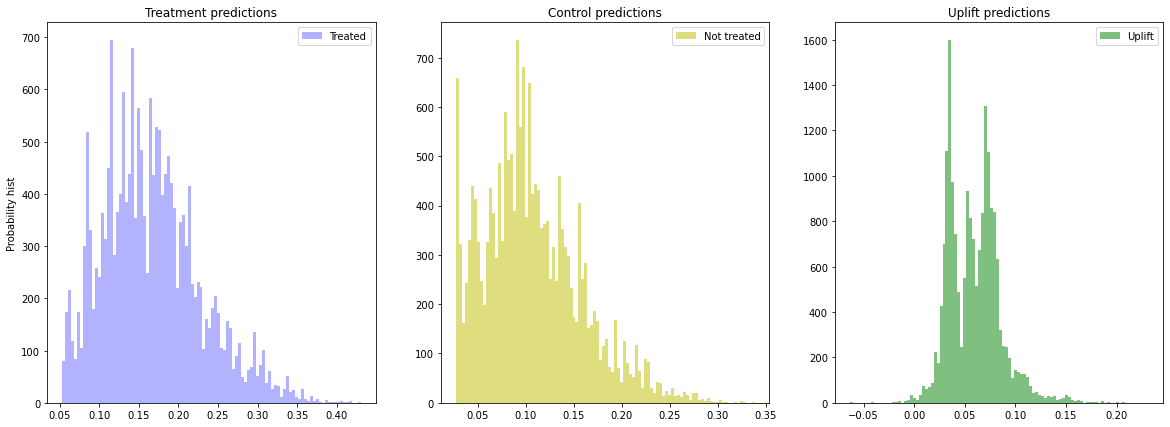

In [22]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)


# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

**ClassTransformation**

In [23]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)

C:\Users\1227458\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


**TwoModels**

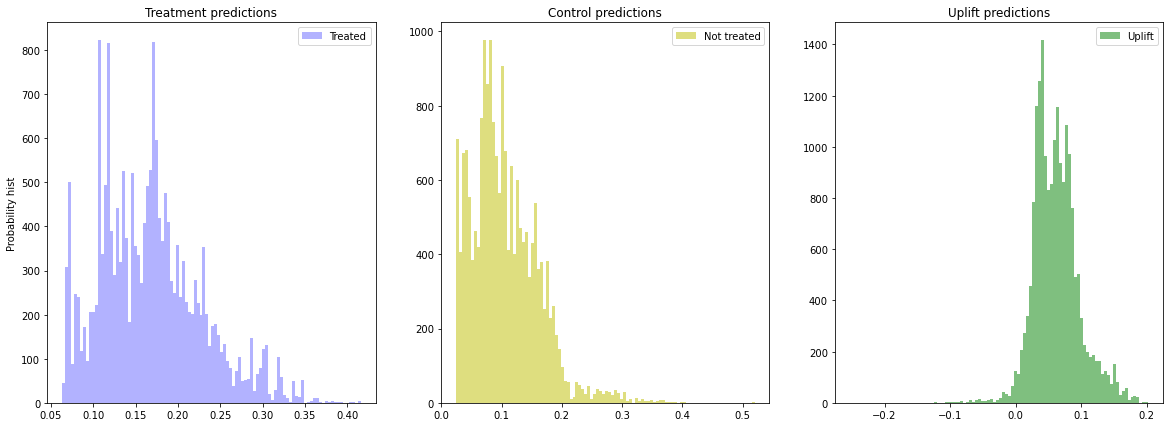

In [24]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Выведем для сравнения таблицу с метриками по каждой модели

In [25]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%
1,ClassTransformation,0.117411
0,SoloModel,0.089254
2,TwoModels,0.078306


In [27]:
from tabulate import tabulate

In [28]:
table=[
       ['ClassTransformation', 0.095800, 0.117411],
       ['SoloModel', 0.078994, 0.089254], 
       ['TwoModels', 0.068439, 0.078306],       
       ]
headers=["approach","uplift@20%", "uplift@10%"]

print(tabulate(table, headers, tablefmt="grid"))

+---------------------+--------------+--------------+
| approach            |   uplift@20% |   uplift@10% |
+=====================+==============+==============+
| ClassTransformation |     0.0958   |     0.117411 |
+---------------------+--------------+--------------+
| SoloModel           |     0.078994 |     0.089254 |
+---------------------+--------------+--------------+
| TwoModels           |     0.068439 |     0.078306 |
+---------------------+--------------+--------------+


In [29]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

Возникли проблемы с установкой модуля